In [1]:
# import display tools
from IPython.display import display, HTML
# set display dimensions
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve)

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import seaborn as sns
from IPython.core.pylabtools import figsize
from IPython.display import display_html
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


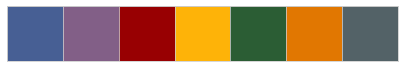

In [4]:
# import custom palette
from custom_modules import my_palette as mp

 > **USER DATA**

In [5]:
# read in first dataset
users_df = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')

In [6]:
# observe dimensionality of dataset
users_df.shape

(12000, 10)

In [7]:
# observe feature name, data type, and possible null values
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


The time features have different data types.<br>
Creation time is an object (string), and last session is a float.

There are missing data to handle, as well.

First, I need to wrangle these column names, way too long.<br>
And what's up with object ID?

In [8]:
users_df.rename(columns={'object_id': 'user_id', 
                         'last_session_creation_time': 'last_session', 
                         'opted_in_to_mailing_list': 'mailing_list', 
                         'enabled_for_marketing_drip': 'marketing_drip', 
                         'invited_by_user_id': 'invitee_id'}, inplace=True)
users_df.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session', 'mailing_list', 'marketing_drip', 'org_id',
       'invitee_id'],
      dtype='object')

I will convert the time features to Pandas Timestamp object.

In [9]:
# check data types
print(type(
    users_df['creation_time'][0]), type(
    users_df['last_session'][0]), sep='\n\n')

<class 'str'>

<class 'numpy.float64'>


In [10]:
# convert time strings to useful  objects
users_df['creation_time'] = pd.to_datetime(
    users_df['creation_time'])
users_df['last_session'] = pd.to_datetime(
    users_df['last_session'], unit='s')

In [11]:
# trust but verify
print(type(
    users_df['creation_time'][0]), type(
    users_df['last_session'][0]), sep='\n\n')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [12]:
# observe some users with missing time data
users_df[users_df['last_session'].isnull()].head(3)

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaT,0,0,130,9270.0


Now, I will impute the missing values in the last session column.<br>
I know that the users were logged in when they signed up.<br>
I will use those dates as the imputed values of the missing last login times.

In [13]:
# create boolean filter to select observations with NaT values
nat_filter = users_df.loc[
    users_df['last_session'].isnull()]['last_session'].index

In [14]:
# impute missing dates with dates of signup
users_df.loc[
    nat_filter, 'last_session'] = users_df.iloc[
    nat_filter]['creation_time']
# check that it worked
users_df[users_df['last_session'].isnull()].head(3)

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id


In [15]:
# observe some data
users_df.head()

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [16]:
# observe some invitees with missing ID data
users_df[users_df['invitee_id'].isnull()].head(3)

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,2013-07-31 05:34:02,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,2013-11-05 04:04:24,0,0,302,NaN


Now, I will encode the users who were not recommended by another user with the value 0.

In [17]:
# check that no one is using ID = 0
users_df[users_df['invitee_id'] == 0]

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id


In [18]:
# create boolean filter to select observations with NaN values
nan_filter = users_df.loc[
    users_df['invitee_id'].isnull()]['invitee_id'].index

In [19]:
# impute missing IDs with the value 0
users_df.loc[
    nan_filter, 'invitee_id'] = 0
# check that it worked
users_df[users_df['last_session'].isnull()].head(3)

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id


In [20]:
# observe new data types and verify the absence of null values
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          12000 non-null  int64         
 1   creation_time    12000 non-null  datetime64[ns]
 2   name             12000 non-null  object        
 3   email            12000 non-null  object        
 4   creation_source  12000 non-null  object        
 5   last_session     12000 non-null  datetime64[ns]
 6   mailing_list     12000 non-null  int64         
 7   marketing_drip   12000 non-null  int64         
 8   org_id           12000 non-null  int64         
 9   invitee_id       12000 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


I will examine the string variables, now.

In [21]:
# look for empty strings
np.sum(users_df[['name', 'email', 'creation_source']].values == '')

0

In [22]:
# observe values for the categorical column
users_df['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

The categories are as expected.

I will extract the service provider from the email string.<br>
It may be useful for prediction.

In [23]:
# break off email feature to inspect
email_df = pd.DataFrame(data=users_df['email'].str.split(
    '@', expand=True)[1].str.split(
    '.', expand=True)[0]).rename(columns={0: 'provider'})
email_df.head()

,provider
0,yahoo
1,gustr
2,gustr
3,yahoo
4,yahoo


In [24]:
# observe values for service providers
email_df['provider'].value_counts()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
              ... 
gzhjb            1
cvwyc            1
ptatt            1
xuifc            1
wwrtt            1
Name: provider, Length: 1184, dtype: int64

With over a thousand providers, I'm not sure it will be useful.

In [25]:
# look for good cutoff
email_df['provider'].value_counts().head(8)

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
xvnbr            2
luque            2
Name: provider, dtype: int64

On second thought, there really are only 6 major providers, then everyone else.<br>
I'll rename the minor providers.

In [26]:
# get a-list of providers
a_provider_lst = email_df['provider'].value_counts().head(6).index.to_list()
a_provider_lst

['gmail', 'yahoo', 'jourrapide', 'cuvox', 'gustr', 'hotmail']

In [27]:
# observe b-list providers
email_df[~email_df['provider'].isin(a_provider_lst)]

,provider
19,uhzdq
42,yyyxt
47,cslyn
63,xhtxh
75,aethf
...,...
11963,owujh
11979,cgbld
11986,uyhoy
11993,eaouk


In [28]:
# rename b-list providers
email_df['provider'][~email_df['provider'].isin(a_provider_lst)] = 'other'
email_df[74:79]

,provider
74,cuvox
75,other
76,jourrapide
77,other
78,gmail


In [29]:
# replace email column with provider column
users_df['email'] = email_df['provider']
users_df.head(3)

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id
0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0


In [30]:
# observe the number of different users who invited another user
users_df['invitee_id'].value_counts()

0.0        5583
10741.0      13
2527.0       12
1525.0       11
2308.0       11
           ... 
7941.0        1
4134.0        1
6101.0        1
129.0         1
594.0         1
Name: invitee_id, Length: 2565, dtype: int64

This is a lot of IDs.<br>
I will create a new feature that reflects whether or not the user was invited.

In [31]:
def set_boolean_value(row, val):
    """Assigns values based on boolean ID condition"""
    return val[row]

In [32]:
# set boolean value assignments
bool_dict = {True: 1, False: 0}

In [33]:
# create binary invited user feature
users_df['invited'] = (users_df['invitee_id'] != 0).apply(
    set_boolean_value, args=(bool_dict, ))
# verify that it worked
users_df[['invitee_id', 'invited']].tail()

,invitee_id,invited
11995,8263.0,1
11996,0.0,0
11997,8074.0,1
11998,0.0,0
11999,0.0,0


In [34]:
# observe the number of different user organizations
users_df['org_id'].value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

Because it's the largest occurence, I'll assume that organization zero identifies no affilaition.<br>
I'll do the same boolean convertion to this category, as well.

In [35]:
# create binary organization member feature
users_df['org_member'] = (users_df['org_id'] != 0).apply(
    set_boolean_value, args=(bool_dict, ))
# verify that it worked
users_df[['org_id', 'org_member']][49:53]

,org_id,org_member
49,61,1
50,0,0
51,0,0
52,37,1


In [36]:
# observe range of variables
users_df.drop(['org_id', 'invitee_id'], axis=1).describe()

,user_id,mailing_list,marketing_drip,invited,org_member
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.249500,0.149333,0.534750,0.973417
std,3464.24595,0.432742,0.356432,0.498812,0.160869
min,1.00000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,0.000000,0.000000,0.000000,1.000000
50%,6000.50000,0.000000,0.000000,1.000000,1.000000
75%,9000.25000,0.000000,0.000000,1.000000,1.000000
max,12000.00000,1.000000,1.000000,1.000000,1.000000


Nearly 25% of those who signed up opted into the marketing emails.<br>
Those who agreed to receive the email marketing drip accounted for just under 15% of all users.<br>
Over 53% of users were invited by another member.<br>
Over 97% of users belong to an organization.

The large number of users who are in an organization and invited by other users may yield some fruitful leads.

In [37]:
# observe some data
users_df.head()

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id,invited,org_member
0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,1
1,2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1,1
4,5,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1,1


This dataset looks good.<br>
I'll work with the other one, now.

 > **LOGIN DATA**

In [38]:
# read in second dataset
engagement_df = pd.read_csv('takehome_user_engagement.csv')

In [39]:
# observe dimensionality of dataset
engagement_df.shape

(207917, 3)

In [40]:
# observe feature names, data types, and possible null values
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


I'll apply the same technique to the time data here, too.

In [41]:
# check data type
print(type(engagement_df['time_stamp'][0]))

<class 'str'>


In [42]:
# convert time string to useful  object
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [43]:
# trust but verify
print(type(engagement_df['time_stamp'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [44]:
# observe timestamp ranges
print(users_df['creation_time'].describe(), 
      engagement_df['time_stamp'].describe(), 
      users_df['last_session'].describe(), sep='\n\n')

count                   12000
unique                  11996
top       2014-02-11 17:57:53
freq                        2
first     2012-05-31 00:43:27
last      2014-05-30 23:59:19
Name: creation_time, dtype: object

count                  207917
unique                 207220
top       2014-02-05 03:09:54
freq                        2
first     2012-05-31 08:20:06
last      2014-06-06 14:58:50
Name: time_stamp, dtype: object

count                   12000
unique                  11998
top       2014-06-04 07:46:58
freq                        2
first     2012-05-31 08:20:06
last      2014-06-06 14:58:50
Name: last_session, dtype: object


Chronologically, the times are aligned in a logical order.<br>
The first signup was May 31st, 2012. All other timestamps are after that one.<br>
The last login was on Juse 6th, 2014. All of the signups are before that date.

In [45]:
# get count of unique user IDs
len(engagement_df['user_id'].unique())

8823

Not all of the users from the first dataset have logins in this dataset.

In [46]:
# observe visited feature
engagement_df['visited'].value_counts()

1    207917
Name: visited, dtype: int64

This is a feature designed to help to count the number of logins when aggregating.

I will use this to count the the occurances of logins in 7 day windows, then sort for adopted users.<br>
Values of 0 will be assigned to users whose activity does not qualify them for adoption.<br>
Values of 1 will be for those users who have been adopted.

I will separate these users into two classes of activity to hunt for insights.<br>
Class 0 will be the users who logged in more than once.<br>
Class 1 will be the one-and-done users, who only logged in once.

In [47]:
def counts_in_window(df):
    """Creates count features for number of logins in 7 day window & retains window data"""
    # get array of unique user IDs
    user_id_arr = df['user_id'].unique()
    # create empty DataFrame
    logins_df = pd.DataFrame(
        index=user_id_arr, 
        columns=['adopted_user', 'loser_class', 'total_logins', 'window_count'])
    # cycle through users
    for user in df['user_id'].unique():
        # partition users
        user_df = df[df['user_id'] == user]
        # get count of logins by 7 day windows
        logins_arr = user_df.rolling(
            '7D', on='time_stamp')['visited'].sum().values.astype('int')
        # assign boolean values to user for adopted and class features
        if logins_arr[logins_arr > 2].size > 0:
            # assign adopted value to adopted users
            logins_df.loc[user, 'adopted_user'] = 1
            # assign class value to adopted users
            logins_df.loc[user, 'loser_class'] = 0    
        else:
            # assign adopted value to users not adopted
            logins_df.loc[user, 'adopted_user'] = 0
            if logins_arr.size > 1:
                # assign class value to users not adopted but active
                logins_df.loc[user, 'loser_class'] = 0
            else:
                # assign class value to one-and-done users
                logins_df.loc[user, 'loser_class'] = 1
        # capture all 7 day window data
        logins_df.loc[user, 'window_count'] = logins_arr
    # get number of logins
    logins_df.loc[:, 'total_logins'] = logins_df['window_count'].apply(sum).values
  
    return logins_df

In [48]:
# create login DataFrame with new features and bring along login window count arrays, just in case
logins_df = counts_in_window(engagement_df).rename_axis('user_id').reset_index()
logins_df[11:15]

,user_id,adopted_user,loser_class,total_logins,window_count
11,17,0,1,1,[1]
12,19,0,0,3,"[1, 2]"
13,20,1,0,12,"[1, 2, 3, 1, 2, 1, 2]"
14,21,0,1,1,[1]


In [49]:
# convert data types for ML algo needs
users_df['invitee_id'] = users_df['invitee_id'].astype(np.int64)
logins_df['adopted_user'] = logins_df['adopted_user'].astype(np.int64)
logins_df['loser_class'] = logins_df['loser_class'].astype(np.int64)

In [50]:
# get number of users in this dataset
logins_df.shape[0]

8823

This one looks good, as well.<br>
I'll put it all together, now.

 > **COMBINED DATA**

In [51]:
# combine user DataFrames
df = users_df.merge(logins_df, on='user_id')
df.head()

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id,invited,org_member,adopted_user,loser_class,total_logins,window_count
0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,1,1,0,1,1,[1]
1,2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,1,1,0,22,"[1, 1, 1, 1, 2, 1, 1, 2, 3, 3, 2, 1, 2, 1]"
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,1,1,0,1,1,[1]
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,1,1,0,1,1,[1]
4,5,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,1,1,0,1,1,[1]


In [52]:
# get percent of adopted users
adopted_percent = df['adopted_user'].value_counts()[1] / df.shape[0] * 100
print('{}% of users have been adopted.'.format(np.round(adopted_percent, 1)))

18.2% of users have been adopted.


As the goal is to increase adopted users, there is a lot of room for improvement.

Let's predict!

 > **MODELING**

I will drop some of the features to start the modeling.<br>
I don't expect a user's Id number or name to be strong predictors.<br>
As for the account creation date and last login date, there may be something there, but I'll see how far I get without them.

In [53]:
# separate data into features and target
X = df.drop(
    ['user_id', 'creation_time', 'name', 'last_session', 
     'adopted_user', 'window_count'], axis=1)
y = df['adopted_user']

In [54]:
# encode categorical variables
X = pd.get_dummies(
    X, prefix={'creation_source': 'source', 'email': 'provider'}).rename(str.lower, axis=1)
X.head()

,mailing_list,marketing_drip,org_id,invitee_id,invited,org_member,loser_class,total_logins,provider_cuvox,provider_gmail,provider_gustr,provider_hotmail,provider_jourrapide,provider_other,provider_yahoo,source_guest_invite,source_org_invite,source_personal_projects,source_signup,source_signup_google_auth
0,1,0,11,10803,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,1,316,1,1,0,22,0,0,1,0,0,0,0,0,1,0,0,0
2,0,0,94,1525,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0
3,0,0,1,5151,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0
4,0,0,193,5240,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0


In [55]:
def get_base_model(features, target):
    """Return base random forest classification model"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    model = RandomForestClassifier(random_state=27, n_jobs=-1)
    model.fit(X_train, y_train)
    
    return model

In [56]:
def get_params(model):
    """Return hyperparameters of interest from classifier"""
    series = pd.Series(
        model.get_params(), name='model_params').drop([
        'bootstrap', 'ccp_alpha', 'class_weight', 'min_impurity_decrease', 
        'min_impurity_split', 'min_weight_fraction_leaf', 'n_jobs', 
        'oob_score', 'random_state', 'verbose', 'warm_start'])
    
    return series

In [57]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

In [58]:
# instantiate base model and get parameters
base_model = get_base_model(X, y)
get_params(base_model)

criterion            gini
max_depth            None
max_features         auto
max_leaf_nodes       None
max_samples          None
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: model_params, dtype: object

In [59]:
def get_reports(features, target, model):
    """Return classification reports, confusion matrices, f1 scores, and PR curves"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)    
    # get classification reports
    cr_train_df = pd.DataFrame(
        classification_report(
            y_train, model.predict(X_train), digits=3, output_dict=True)).transpose()
    cr_test_df = pd.DataFrame(
        classification_report(
            y_test, model.predict(X_test), digits=3, output_dict=True)).transpose()
    # get confusion matrices
    cm_train_df = pd.DataFrame(
        confusion_matrix(y_train, model.predict(X_train)))
    cm_test_df = pd.DataFrame(
        confusion_matrix(y_test, model.predict(X_test)))
    # prep data for HTML display
    df1_styler = cr_train_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Training Classification Report')
    df2_styler = cr_test_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Test Classification Report')
    df3_styler = cm_train_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Training Confusion Matrix')
    df4_styler = cm_test_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Test Confusion Matrix')
    # display reports and matrices
    display_html(
        df1_styler._repr_html_() 
        + df2_styler._repr_html_() 
        + df3_styler._repr_html_() 
        + df4_styler._repr_html_(), raw=True) 
    # get values from confusion matrices
    tp_train = cm_train_df.loc[0, 0]
    fn_train = cm_train_df.loc[0, 1]
    fp_train = cm_train_df.loc[1, 0]
    tn_train = cm_train_df.loc[1, 1]
    tp_test = cm_test_df.loc[0, 0]
    fn_test = cm_test_df.loc[0, 1]
    fp_test = cm_test_df.loc[1, 0]
    tn_test = cm_test_df.loc[1, 1] 
    # get f1 scores
    f1_train = 2 * tp_train / (2 * tp_train + fp_train + fn_train)
    f1_test = 2 * tp_test / (2 * tp_test + fp_test + fn_test)     
    # get PR curve data
    precision_train, recall_train = precision_recall_curve(
        y_train, model.predict(X_train))[:2]
    precision_test, recall_test = precision_recall_curve(
        y_test, model.predict(X_test))[:2]
    # plot precision recall curves
    sns.lineplot(recall_train, precision_train, color=mp.colors(4), label='Training Model')
    sns.lineplot(recall_test, precision_test, color=mp.colors(5), label='Test Model')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.legend(loc=3)
    plt.title('Precision Recall Curves');
    
    return f'Training f1 Score: {f1_train:.4f}    Test f1 Score: {f1_test:.4f}'    

,precision,recall,f1-score,support
0,0.999783,1.000000,0.999891,4601.000000
1,1.000000,0.999043,0.999521,1045.000000
accuracy,0.999823,0.999823,0.999823,0.999823
macro avg,0.999891,0.999522,0.999706,5646.000000
weighted avg,0.999823,0.999823,0.999823,5646.000000
,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,1165.000000
1,1.000000,1.000000,1.000000,247.000000
accuracy,1.000000,1.000000,1.000000,1.000000
macro avg,1.000000,1.000000,1.000000,1412.000000


'Training f1 Score: 0.9999    Test f1 Score: 1.0000'

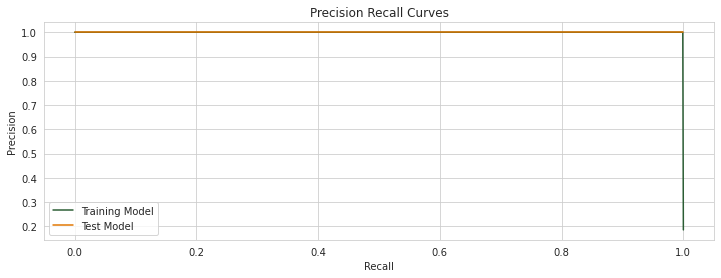

In [60]:
# observe classification metrics
get_reports(X_train, y_train, base_model)

In [61]:
def plot_feature_importance(features, model):
    """Plots the predictors by importance to model"""
    # create DataFrame of importances
    importance_df = pd.DataFrame(
        [model.feature_importances_], 
        index=['importance'], 
        columns=features.columns).transpose().sort_values('importance', ascending=False)
    # set grid
    fig, axes = plt.subplots(nrows=1, figsize=(12, 8))
    # set y range
    y_range = list(range(importance_df.shape[0]))
    
    plt.subplot(1, 1, 1)
    sns.barplot(importance_df['importance'], y_range, 
                orient='h', color=mp.colors(1))
    
    plt.yticks(y_range, importance_df.index.to_list())
    plt.xlabel('Feature Importance', fontsize=15);
    plt.ylabel('Feature', fontsize=15)
    
    plt.title('Feature Importance for Predictions', fontsize=15);
    
    return importance_df

,importance
total_logins,0.660596
loser_class,0.255706
org_id,0.037187
invitee_id,0.019019
mailing_list,0.003531
marketing_drip,0.002791
provider_hotmail,0.002362
provider_gmail,0.002349
source_guest_invite,0.001966
provider_yahoo,0.001882


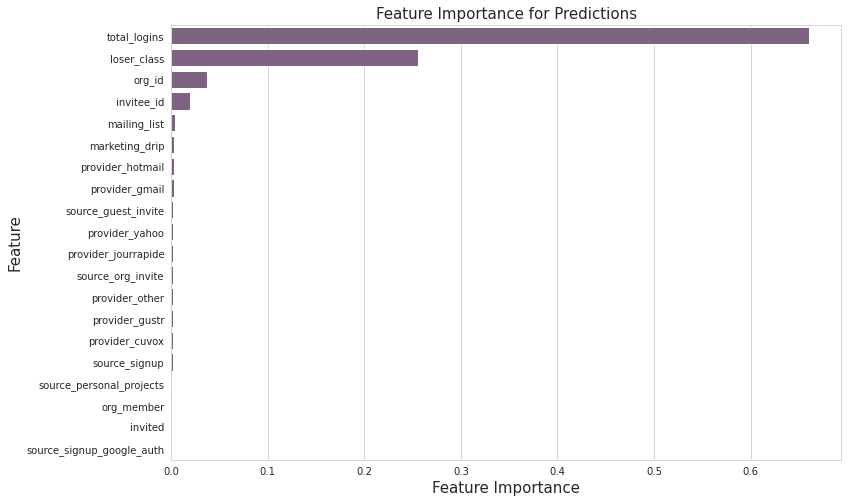

In [62]:
# list feature importances and plot
plot_feature_importance(X_train, base_model)

The model performs too well.<br>
Saying users are more likely to be adopted if they log in more is almost trivial.<br>
It's difficult to observe what other factors may be in play.<br>
I will remove the dominant feature to gain deeper insight.

In [63]:
# separate data into features and target without login count
X_no_count = df.drop(
    ['user_id', 'creation_time', 'name', 'last_session', 
     'adopted_user', 'total_logins', 'window_count'], axis=1)
y_no_count = df['adopted_user']

In [64]:
# encode categorical variables
X_no_count = pd.get_dummies(
    X_no_count, 
    prefix={'creation_source': 'source', 'email': 'provider'}).rename(str.lower, axis=1)
X_no_count.head()

,mailing_list,marketing_drip,org_id,invitee_id,invited,org_member,loser_class,provider_cuvox,provider_gmail,provider_gustr,provider_hotmail,provider_jourrapide,provider_other,provider_yahoo,source_guest_invite,source_org_invite,source_personal_projects,source_signup,source_signup_google_auth
0,1,0,11,10803,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,1,316,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0,0,94,1525,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0
3,0,0,1,5151,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0
4,0,0,193,5240,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0


In [65]:
# split dataset
X_train_no_count, X_test_no_count, y_train_no_count, y_test_no_count = train_test_split(
    X_no_count, y_no_count, test_size=0.2, random_state=27)

In [66]:
# instantiate base model and get parameters
base_model_no_count = get_base_model(X_no_count, y_no_count)
get_params(base_model_no_count)

criterion            gini
max_depth            None
max_features         auto
max_leaf_nodes       None
max_samples          None
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: model_params, dtype: object

,precision,recall,f1-score,support
0,0.997172,0.996305,0.996738,4601.000000
1,0.983794,0.987560,0.985673,1045.000000
accuracy,0.994687,0.994687,0.994687,0.994687
macro avg,0.990483,0.991932,0.991206,5646.000000
weighted avg,0.994696,0.994687,0.994690,5646.000000
,precision,recall,f1-score,support
0,0.997418,0.994850,0.996132,1165.000000
1,0.976000,0.987854,0.981891,247.000000
accuracy,0.993626,0.993626,0.993626,0.993626
macro avg,0.986709,0.991352,0.989012,1412.000000


'Training f1 Score: 0.9967    Test f1 Score: 0.9961'

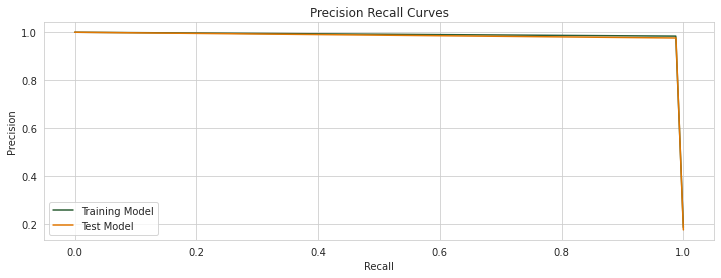

In [67]:
# observe classification metrics
get_reports(X_train_no_count, y_train_no_count, base_model_no_count)

,importance
loser_class,0.528232
org_id,0.272917
invitee_id,0.119679
mailing_list,0.015101
marketing_drip,0.011125
provider_yahoo,0.005546
provider_gmail,0.005527
provider_gustr,0.005146
provider_hotmail,0.005004
provider_jourrapide,0.004724


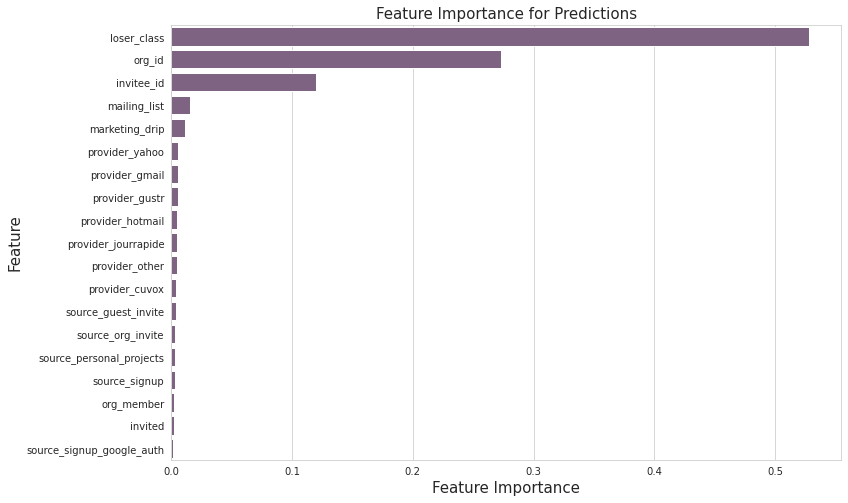

In [68]:
# list feature importances and plot
plot_feature_importance(X_train_no_count, base_model_no_count)

Great. The model still has excellent performance, without the obvious observation.

The loser class is important to observe.<br>
It distinguishes those users who are still active from ones who never really joined, as well as the adopted users.<br>
These active users should be recruited for more activity, until they become adopted.<br>
For clarification, they will have values of 0 for loser class and 0 for adopted class.

In [69]:
# extract the users that never stuck around
loser_users_df = df[df['loser_class'] == 1]
loser_users_df.shape[0]

6235

In [70]:
# extract the users that should get more attention
target_users_df = df[(df['loser_class'] == 0) & (df['adopted_user'] == 0)]
target_users_df.shape[0]

986

In [71]:
# extract the users that are adopted
adopted_users_df = df[df['adopted_user'] == 1]
adopted_users_df.shape[0]

1602

There are quit a lot of people who are in the data, but are not active users.

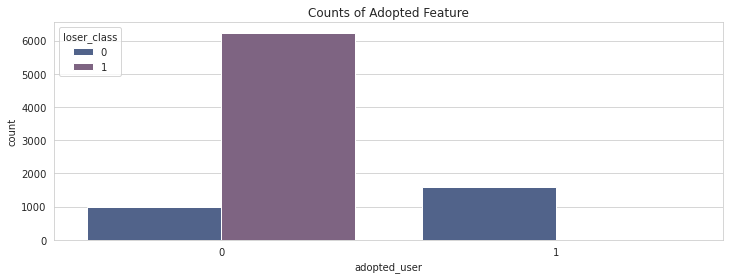

In [72]:
# plot counts of adopted users and users not considered adopted, split by active users
sns.countplot(x='adopted_user', hue='loser_class', data=df)
plt.title('Counts of Adopted Feature');

Since organization ID was an important feature, I will contrast membership with respect to the different types of users.

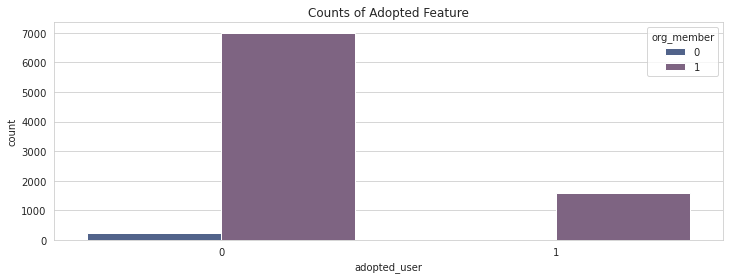

In [73]:
# plot counts of adopted users and users not adopted, split by organizational membership
sns.countplot(x='adopted_user', hue='org_member', data=df)
plt.title('Counts of Adopted Feature');

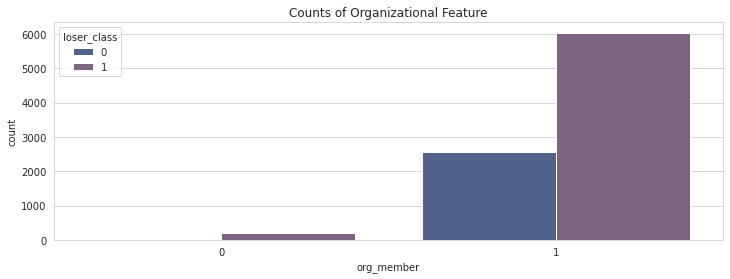

In [74]:
# plot counts of organizational membership, split by active users
sns.countplot(x='org_member', hue='loser_class', data=df)
plt.title('Counts of Organizational Feature');

Most of the adopted users belonged to an organization, but so did most of the users that were not active.<br>
I will look for distinctions with respect to whether or not the person was invited by another user.

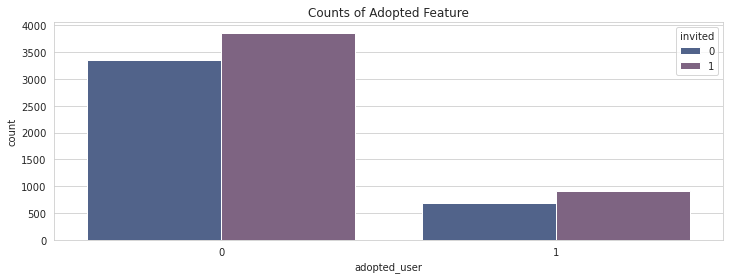

In [75]:
# plot counts of adopted users and users not adopted, split by member invitation
sns.countplot(x='adopted_user', data=df, hue='invited')
plt.title('Counts of Adopted Feature');

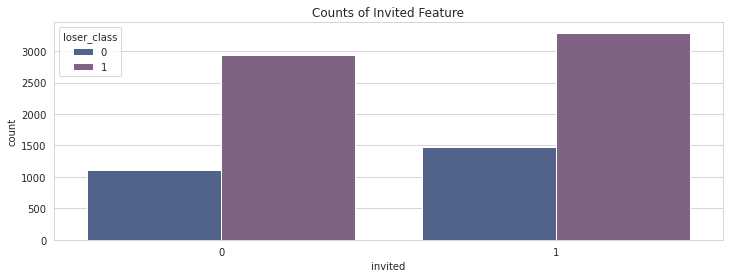

In [76]:
# plot counts of member invitation, split by active users
sns.countplot(x='invited', data=df, hue='loser_class')
plt.title('Counts of Invited Feature');

The splits are fairly even, here.<br>
I feel that the amount of not active users is dominating the comparison.<br>
I will remove those users and look for distinctions between the other two groups.

In [77]:
# group the active users to distinguish them
active_users_df = pd.concat([target_users_df, adopted_users_df])
active_users_df.shape[0]

2588

In [78]:
# separate data into features and target with only active users
X_no_losers = active_users_df.drop(
    ['user_id', 'creation_time', 'name', 'last_session', 
     'adopted_user', 'loser_class', 'total_logins', 'window_count'], axis=1)
y_no_losers = active_users_df['adopted_user']

In [79]:
# encode categorical variables
X_no_losers = pd.get_dummies(
    X_no_losers, 
    prefix={'creation_source': 'source', 'email': 'provider'}).rename(str.lower, axis=1)
X_no_losers.head()

,mailing_list,marketing_drip,org_id,invitee_id,invited,org_member,provider_cuvox,provider_gmail,provider_gustr,provider_hotmail,provider_jourrapide,provider_other,provider_yahoo,source_guest_invite,source_org_invite,source_personal_projects,source_signup,source_signup_google_auth
12,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
18,1,0,81,6312,1,1,0,0,0,0,1,0,0,1,0,0,0,0
44,0,0,325,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
45,0,0,88,3463,1,1,0,1,0,0,0,0,0,0,1,0,0,0
59,1,1,68,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0


In [80]:
# split dataset
X_train_no_losers, X_test_no_losers, y_train_no_losers, y_test_no_losers = train_test_split(
    X_no_losers, y_no_losers, test_size=0.2, random_state=27)

In [81]:
# instantiate base model and get parameters
base_model_no_losers = get_base_model(X_no_losers, y_no_losers)
get_params(base_model_no_losers)

criterion            gini
max_depth            None
max_features         auto
max_leaf_nodes       None
max_samples          None
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: model_params, dtype: object

,precision,recall,f1-score,support
0,0.975166,0.959283,0.967159,614.000000
1,0.976236,0.985605,0.980898,1042.000000
accuracy,0.975845,0.975845,0.975845,0.975845
macro avg,0.975701,0.972444,0.974029,1656.000000
weighted avg,0.975839,0.975845,0.975804,1656.000000
,precision,recall,f1-score,support
0,0.987421,0.993671,0.990536,158.000000
1,0.996078,0.992188,0.994129,256.000000
accuracy,0.992754,0.992754,0.992754,0.992754
macro avg,0.991750,0.992929,0.992333,414.000000


'Training f1 Score: 0.9672    Test f1 Score: 0.9905'

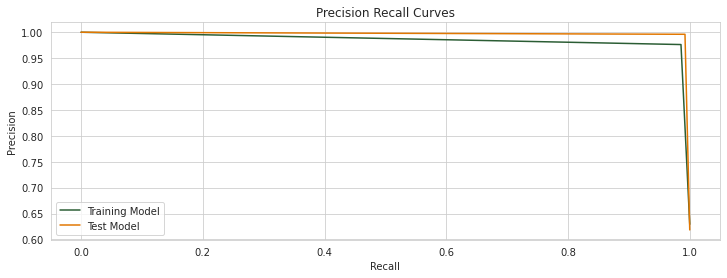

In [82]:
# observe classification metrics
get_reports(X_train_no_losers, y_train_no_losers, base_model_no_losers)

,importance
org_id,0.580608
invitee_id,0.242541
mailing_list,0.027722
marketing_drip,0.020142
provider_gmail,0.013153
provider_yahoo,0.012641
provider_other,0.011584
provider_gustr,0.011576
provider_jourrapide,0.011049
provider_hotmail,0.010888


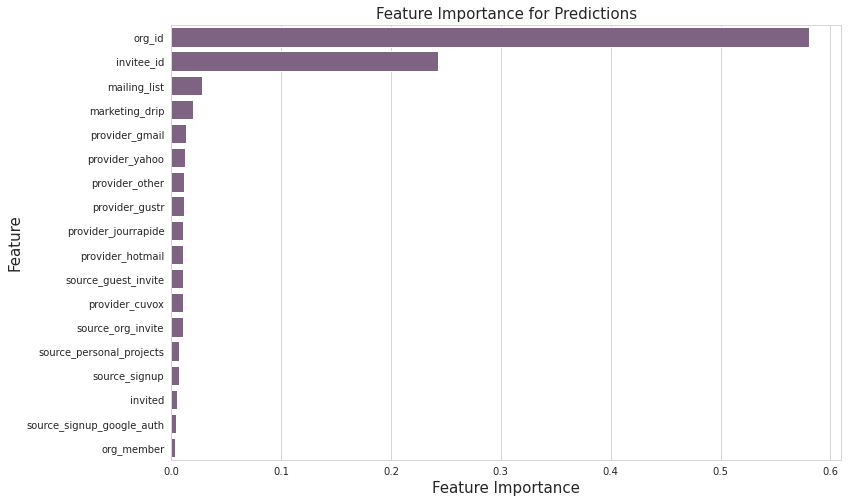

In [83]:
# list feature importances an plot
plot_feature_importance(X_train_no_losers, base_model_no_losers)

There's not much difference, here.<br>
I will note that the particular user invitee and affiliated organization appear important.

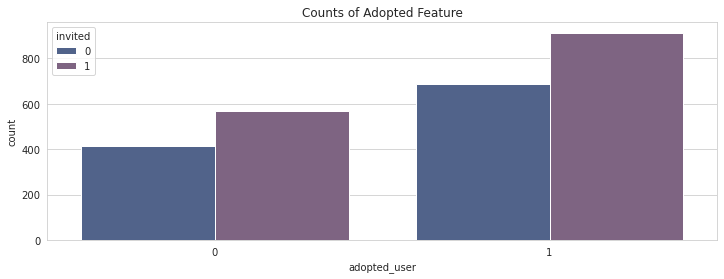

In [84]:
# plot counts of adopted users and people are just active, split by invitation class
sns.countplot(x='adopted_user', data=active_users_df, hue='invited')
plt.title('Counts of Adopted Feature');

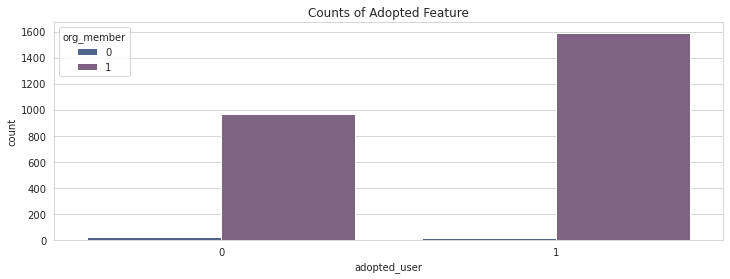

In [85]:
# plot counts of adopted users and people are just active, split by organization class
sns.countplot(x='adopted_user', data=active_users_df, hue='org_member')
plt.title('Counts of Adopted Feature');

Whether the user was invited to join or is a member of an organization, in general, doesn't seem to correlate with being an adopted user.

Let me see if I can get some details about the specific organizations and invitees.

In [86]:
# sort organizations by their adopted power
adopted_dict = adopted_users_df['org_id'].value_counts().to_dict()
loser_dict = loser_users_df['org_id'].value_counts().to_dict()
average_dict = {}
perfect_dict = {}

for org, adopted in adopted_dict.items():
    if org in loser_dict.keys():
        average_dict[org] = loser_dict[org] / adopted
    else:
        perfect_dict[org] = adopted
perfect_dict

{}

It looks like there's no organization that has all of its member who are adopted.<br>
I'll find the ones that are batting better than .500.

In [87]:
# get best groups for adopted members
best_dict = {k:v for (k, v) in average_dict.items() if v < 1}
best_dict

{161: 0.7142857142857143,
 387: 0.5714285714285714,
 235: 0.6666666666666666,
 289: 0.6666666666666666,
 248: 0.8333333333333334,
 306: 0.8333333333333334,
 392: 0.8333333333333334,
 273: 0.8,
 381: 0.75,
 231: 0.75,
 352: 0.6666666666666666,
 359: 0.5}

These are the organizations with at least half of their members being adopted users.<br>
There should be a focus on expanding the membership of these groups, as they may lend themselves to regular activity.

In [88]:
# get groups with no adopted members
bad_org_lst = np.setdiff1d(list(loser_dict.keys()), list(average_dict.keys()))
bad_dict = {}
for org in bad_org_lst:
    bad_dict[org] = loser_dict[org]
bad_dict

{151: 9,
 183: 8,
 237: 13,
 242: 13,
 279: 10,
 299: 15,
 307: 9,
 310: 8,
 329: 6,
 346: 9,
 355: 7,
 362: 13,
 365: 7,
 394: 14,
 396: 5,
 412: 6,
 416: 2}

These organizations have no adopted members.<br>
These two groups of organizations, above, should be compared with additional data.

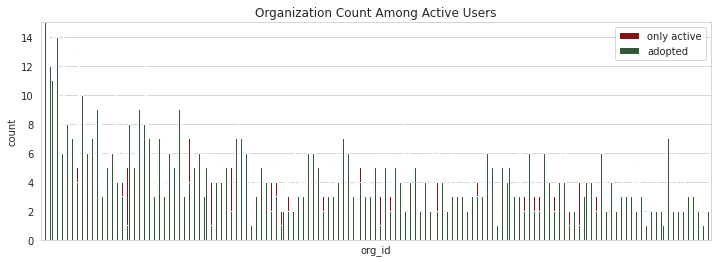

In [89]:
# plot counts of organizations, split by adopted feature among active users
plt.ylim(0, 15)

sns.countplot(target_users_df['org_id'], label='only active', color=mp.colors(2))
sns.countplot(adopted_users_df['org_id'], label='adopted', color=mp.colors(4))

plt.xticks([])
plt.legend()
plt.title('Organization Count Among Active Users');

There are some organizations in red, rising above the green, that should have more of their members be adopted.<br>
Outreach should be done to these classes to get their members' activities more frequent.

I'll do the same sorting of people who invited their friends.

In [90]:
# sort members by their adopted power
adopted_friend_dict = adopted_users_df['invitee_id'].value_counts().to_dict()
loser_friend_dict = loser_users_df['invitee_id'].value_counts().to_dict()
average_friend_dict = {}
perfect_friend_dict = {}

for org, adopted in adopted_friend_dict.items():
    if org in loser_friend_dict.keys():
        average_friend_dict[org] = loser_friend_dict[org] / adopted
    else:
        perfect_friend_dict[org] = adopted
# get those people who have recruited more than two adopted users
best_perfect_friend_dict = {k:v for (k, v) in perfect_friend_dict.items() if v > 2}
best_perfect_friend_dict

{5910: 3, 2776: 3, 8602: 3, 879: 3, 4019: 3}

These four people have recruited the most users who went on to become adopted users.

In [91]:
# find the best recruiters
df[df['user_id'].isin(best_perfect_friend_dict.keys())]

,user_id,creation_time,name,email,creation_source,last_session,mailing_list,marketing_drip,org_id,invitee_id,invited,org_member,adopted_user,loser_class,total_logins,window_count
2017,2776,2012-09-07 02:12:26,Robertson Mia,yahoo,ORG_INVITE,2012-10-31 02:12:26,0,0,24,11085,1,1,0,0,10,"[1, 1, 2, 2, 1, 1, 2]"
2956,4019,2012-06-11 08:28:50,Kjær Elias,cuvox,GUEST_INVITE,2014-06-04 08:28:50,0,0,305,4019,1,1,1,0,3085,"[1, 2, 1, 1, 2, 3, 4, 1, 1, 2, 2, 3, 3, 3, 2, ..."
4329,5910,2012-09-23 07:04:05,Neudorf Philipp,jourrapide,GUEST_INVITE,2012-09-24 07:04:05,0,0,212,6195,1,1,0,1,1,[1]
6289,8602,2012-10-25 07:46:58,May Julian,other,ORG_INVITE,2014-06-04 07:46:58,0,0,387,8602,1,1,1,0,1231,"[1, 2, 1, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 3, ..."


Strangely enough, Neudorf Philipp only has one login, but has recruited three adopted users.<br>
Robertson Mia is not an adopted user, either.<br>
I recommend collecting further data on users, such as age, gender, occupation, zip code, etc.

To conclude, there are correlations between the target and the organizations and invitees.<br>
Unfortunately, I don't believe the right kind of data is present to present much understanding for said correlations.<br>
I would like to see more information about the users and the available organizations, before speculating further.